In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys
sys.path.append("../2_train_models")
from file_configs import MergedFilesConfig
from data_loading import extract_observed_profiles

from other_motif_utils import compute_per_position_ic, plot_motif_on_ax, trim_motifs_by_same_thresh

In [71]:
# specify what set of models to look at
cell_type = "K562"

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

dpr_pattern_indexes = [10, 11, 12, 14, 16, 18, 20, 25, 26, 30]
te_pattern_prof_indexes = [22, 24, 27, 31, 32, 34, 36, 37, 38]
te_pattern_counts_indexes = [16, 21, 22, 24, 25, 26, 27, 28, 30, 32]

In [64]:
# Load the config object (filepath holder) for these models
config = MergedFilesConfig(cell_type, model_type, data_type)

proj_dir = config.proj_dir
figures_dir = proj_dir + "figures/"

genome_path = config.genome_path
chrom_sizes = config.chrom_sizes

# modisco results hdf5 object containing the motifs/patterns and subpatterns
modisco_results_path = config.modisco_profile_results_path
counts_modisco_results_path = config.modisco_counts_results_path

# what window length was used when contribution scores were input to modisco
# (needed to adjust seqlet coordinates)
slice_len = config.slice

In [4]:
# Load observed and predicted data across all PRO-cap peaks

true_profs = extract_observed_profiles(config.plus_bw_path,
                                       config.minus_bw_path,
                                       config.all_peak_path,
                                       out_window=out_window)

pred_profs = np.exp(np.load(config.pred_profiles_all_path))

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [5]:
# normalize the observed profiles to sum to 1,
# so that in later plots, individual peaks don't dominate

def normalize(profile, axis=-1):
    profile_sum = np.sum(profile, axis=axis, keepdims=True)
    
    # If any strand has no signal on it,
    # keep 0 as the quotient instead of dividing by 0
    profile_sum[profile_sum == 0] = 1  
    
    return profile / profile_sum


true_profs_norm = normalize(true_profs)

In [6]:
def extract_profs_at_seqlets(seqlets, profiles,
                             out_window=out_window, target_prof_width=200):

    # note that this function won't work correctly if your out_window
    # doesn't match what your slice_len was set to when you ran modisco!
    # (seqlet coordinates will be off)
    
    assert len(profiles.shape) == 3 and profiles.shape[-1] == out_window, profiles.shape
    assert target_prof_width <= out_window // 2
    
    # extract coordinates for each seqlet
    peak_indexes = seqlets["example_idx"][:]
    seqlet_starts = seqlets["start"][:]
    seqlet_ends = seqlets["end"][:]
    seqlet_rcs = seqlets["is_revcomp"][:]
    
    # get coordinate centered on the seqlet center to extract the data profile around
    seqlet_mids = (seqlet_starts + seqlet_ends) // 2
    
    
    # For each seqlet, fetch the true/predicted profiles
    
    seqlet_profs = []
    for peak_index, seqlet_mid, is_seqlet_rc in zip(peak_indexes, seqlet_mids, seqlet_rcs):
        prof_start = seqlet_mid - target_prof_width
        prof_end = prof_start + target_prof_width * 2
        
        if prof_start < 0 or prof_end > out_window:
            # the seqlet is too close to the edge of the profile,
            # so we will pad with nans (ignored during averaging later)
        
            adjusted_prof_start = max(0, prof_start)
            adjusted_prof_end = min(out_window, prof_end)
            
            subset_of_prof = profiles[peak_index, :, adjusted_prof_start:adjusted_prof_end]
            
            num_bases_missing = target_prof_width * 2 - subset_of_prof.shape[-1]
            padded_array = np.full((subset_of_prof.shape[0], num_bases_missing), np.nan)
            
            if prof_start < 0:
                # the seqlet was too far left, so adjust the profile by shifting to the right
                prof_at_seqlet = np.concatenate((padded_array, subset_of_prof), axis=1)
            else:
                # the seqlet was too far right, so adjust the profile by shifting to the left
                prof_at_seqlet = np.concatenate((subset_of_prof, padded_array), axis=1)
                
        else:
            prof_at_seqlet = profiles[peak_index, :, prof_start:prof_end]
            
            if prof_at_seqlet.shape[-1] == 0:
                print(peak_index, prof_start, prof_end)
            
        
        if is_seqlet_rc:
            # we want to align profiles with respect to motif orientation.
            # so if the motif is flipped, flip the profile too (and swap strands)
            prof_at_seqlet = prof_at_seqlet[::-1, ::-1]
        
        seqlet_profs.append(prof_at_seqlet)  
    
    seqlet_profs = np.stack(seqlet_profs)
    
    assert seqlet_profs.shape[-1] == target_prof_width * 2, seqlet_profs.shape
    return seqlet_profs

In [66]:
def load_pattern_info_from_modisco_results(results_path, pattern_i):
    # parse the file structure of the modisco results hdf5 file to pull out
    # the pwm, cwm, and seqlet (seqlet = loci clustered into the motif) info;
    # then use the seqlet info to extract the observed/predicted PRO-cap profiles
    # at every seqlet.

    h5_file = h5py.File(results_path, "r")
    
    pattern_group_name = "pos_patterns"
    assert pattern_group_name in ['pos_patterns', 'neg_patterns'], pattern_group_name
        
    assert pattern_group_name in h5_file.keys(), pattern_group_name
    
    new_patterns_grp = h5_file[pattern_group_name]
    assert len(new_patterns_grp.keys()) > 0, pattern_group_name
    
    pattern_grp = new_patterns_grp["pattern_" + str(pattern_i)]

    pattern_pwm = pattern_grp["sequence"][:]
    pattern_cwm = pattern_grp["contrib_scores"][:]
    seqlets = pattern_grp["seqlets"]
    
    true_profs_at_seqlets = extract_profs_at_seqlets(seqlets, true_profs_norm)
    pred_profs_at_seqlets = extract_profs_at_seqlets(seqlets, pred_profs)
    
    h5_file.close()
    
    return pattern_pwm, pattern_cwm, true_profs_at_seqlets, pred_profs_at_seqlets

In [81]:
def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False,
                     color = None, tick_len=3, tick_fontsize=5):
    assert len(profiles.shape) == 3

    # Compute the mean profiles across all examples
    profs_mean = np.nanmean(profiles, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color=color, linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color=color, alpha = 0.6, linewidth=0.5)

    # aesthetics -- set axes
    
    max_mean_val = np.max(profs_mean)
    
    if tick_len < 3:
        mean_ylim = max_mean_val * 1.1  # Make 5% higher
    else:
        mean_ylim = max_mean_val * 1.
        
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        ax.spines[["left", "top", "right", "bottom"]].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=tick_fontsize)
        ax.tick_params("x", length=tick_len, labelsize=5, pad=2)
        
        ax.spines[["left", "top", "right"]].set_visible(False)
            
        if tick_len < 3:
            rect = patches.Rectangle((0, -mean_ylim * 1.55), prof_width - 6, mean_ylim / 7,
                                     clip_on=False, zorder=50, color="white")
        else:
            rect = patches.Rectangle((0, -mean_ylim * 1.55), prof_width - 4, mean_ylim / 5,
                                     clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim * 1.5))
        ax.spines["bottom"].set_color("#333333")
        


def plot_pattern_mult_subpatterns_and_profs(pattern_infos, save_path = None):
    
    fig, axes = plt.subplots(len(pattern_infos), 4,
                             figsize = (5, 0.4 * len(pattern_infos)),
                             gridspec_kw={'width_ratios': [1,1,0.7,0.7]},
                             dpi = 300)
    
    plot_colors = ["#001DAC", "#1B5AE3"]
    
    for row_i, pattern_info in enumerate(pattern_infos):
        ax_row = axes[row_i]
        
        # unpack all the info needed for the plot,

        pattern_pwm, pattern_cwm, true_profs_at_seqlets, pred_profs_at_seqlets = pattern_info

        # convert from PFM to actual PWM
        pattern_pwm = pattern_pwm * compute_per_position_ic(pattern_pwm)[:, None]
    
        # plot sequence representation and average profiles for each pattern

        plot_motif_on_ax(pattern_pwm, ax_row[0])
        plot_motif_on_ax(pattern_cwm, ax_row[1])

        plot_avg_profile(true_profs_at_seqlets, ax_row[2], color = plot_colors[0])
        plot_avg_profile(pred_profs_at_seqlets, ax_row[3], color = plot_colors[1],
                         bottom_ticks = row_i == len(pattern_infos) - 1)
    
    
    # aesthetics
    
    top_fontsize = 7
    axes[0,0].set_title("PWM", fontsize=top_fontsize, y=1.2)
    axes[0,1].set_title("CWM", fontsize=top_fontsize, y=1.2)
    axes[0,2].set_title("Avg. Observed\nProfile", fontsize=top_fontsize)
    axes[0,3].set_title("Avg. Predicted\nProfile", fontsize=top_fontsize)
        
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0., dpi = 300)
    
    plt.show()

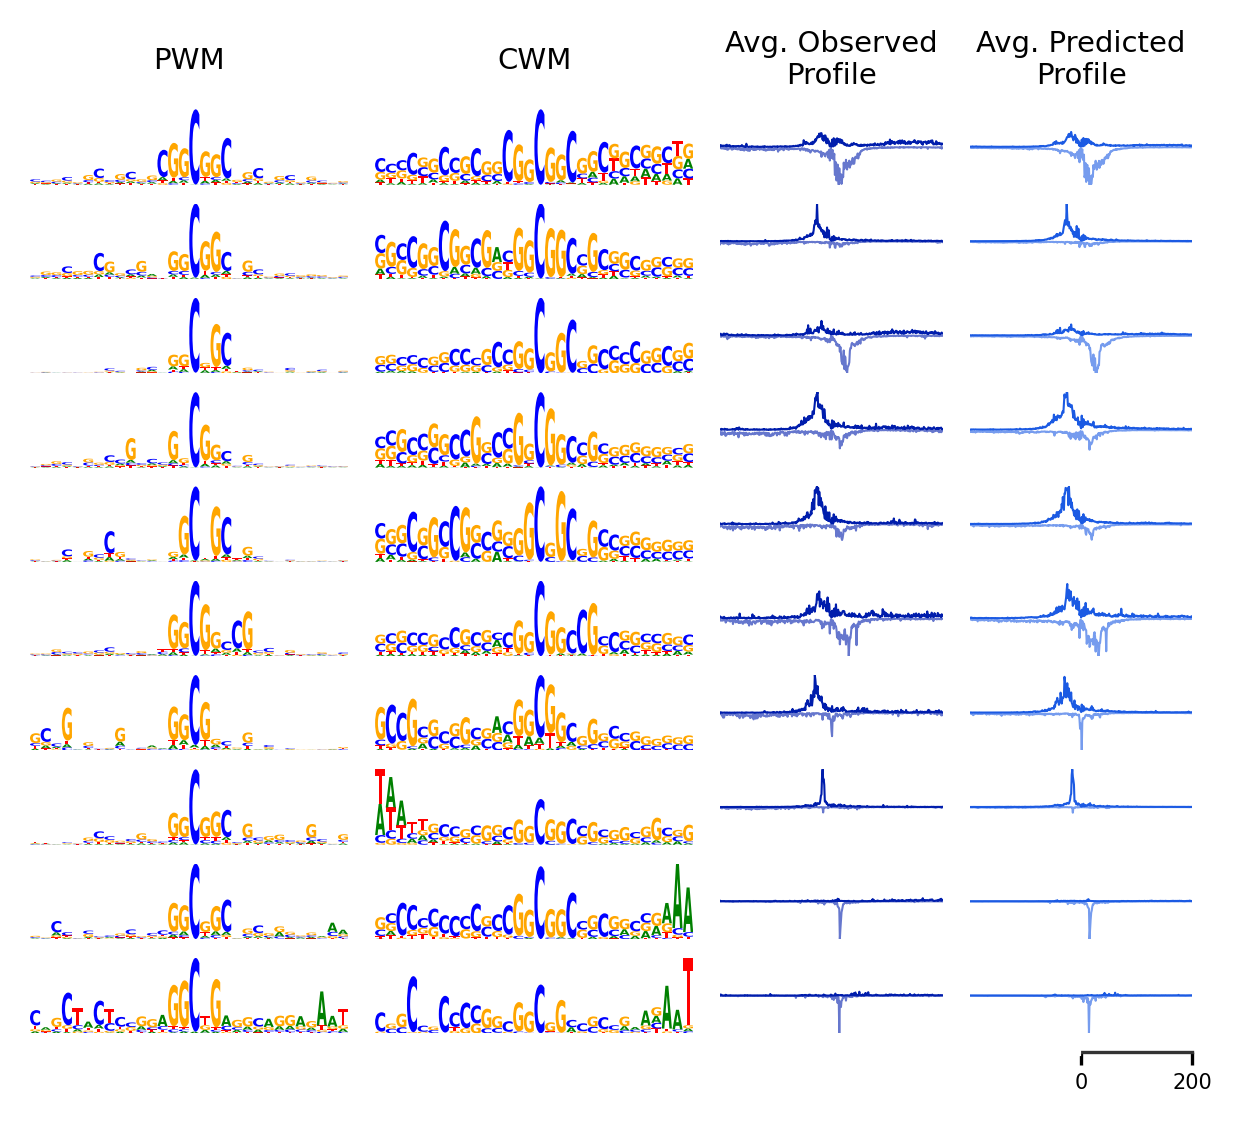

In [82]:
def plot_multi_subclusters(results_path, pattern_is, save_path = None):
    # pattern_is = list of indexes of the modisco hits/patterns/motifs to plot

    pattern_infos = []
    for pattern_i in pattern_is:
        info = load_pattern_info_from_modisco_results(results_path, pattern_i)
        pattern_infos.append(info)

    plot_pattern_mult_subpatterns_and_profs(pattern_infos, save_path = save_path)


plot_multi_subclusters(modisco_results_path, dpr_pattern_indexes,
                       save_path = figures_dir + "S2_dpr_patterns.png" )

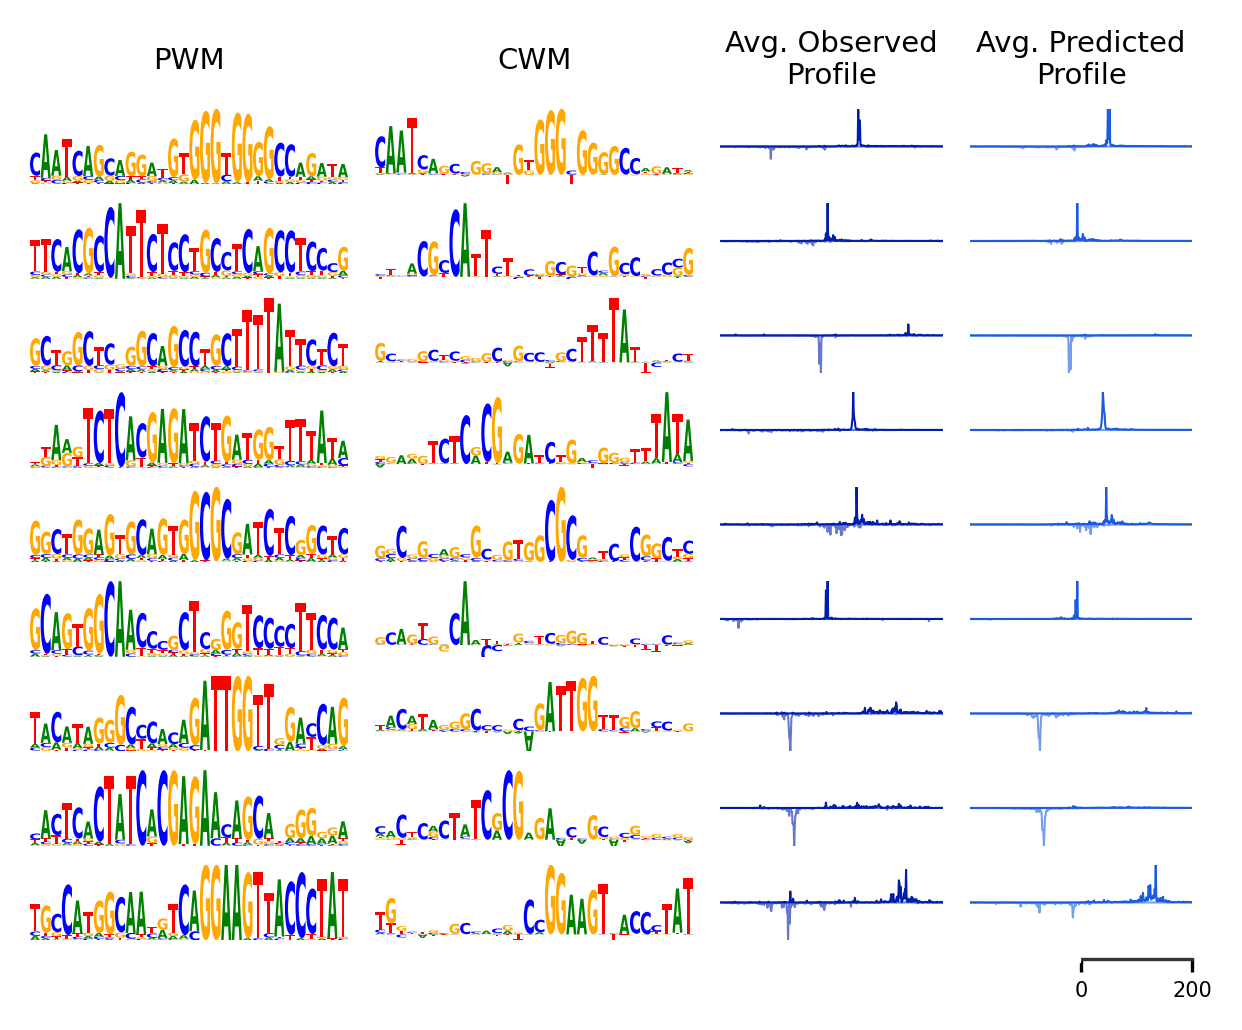

In [83]:
plot_multi_subclusters(modisco_results_path, te_pattern_prof_indexes,
                       save_path = figures_dir + "S2_te_patterns_prof.png" )

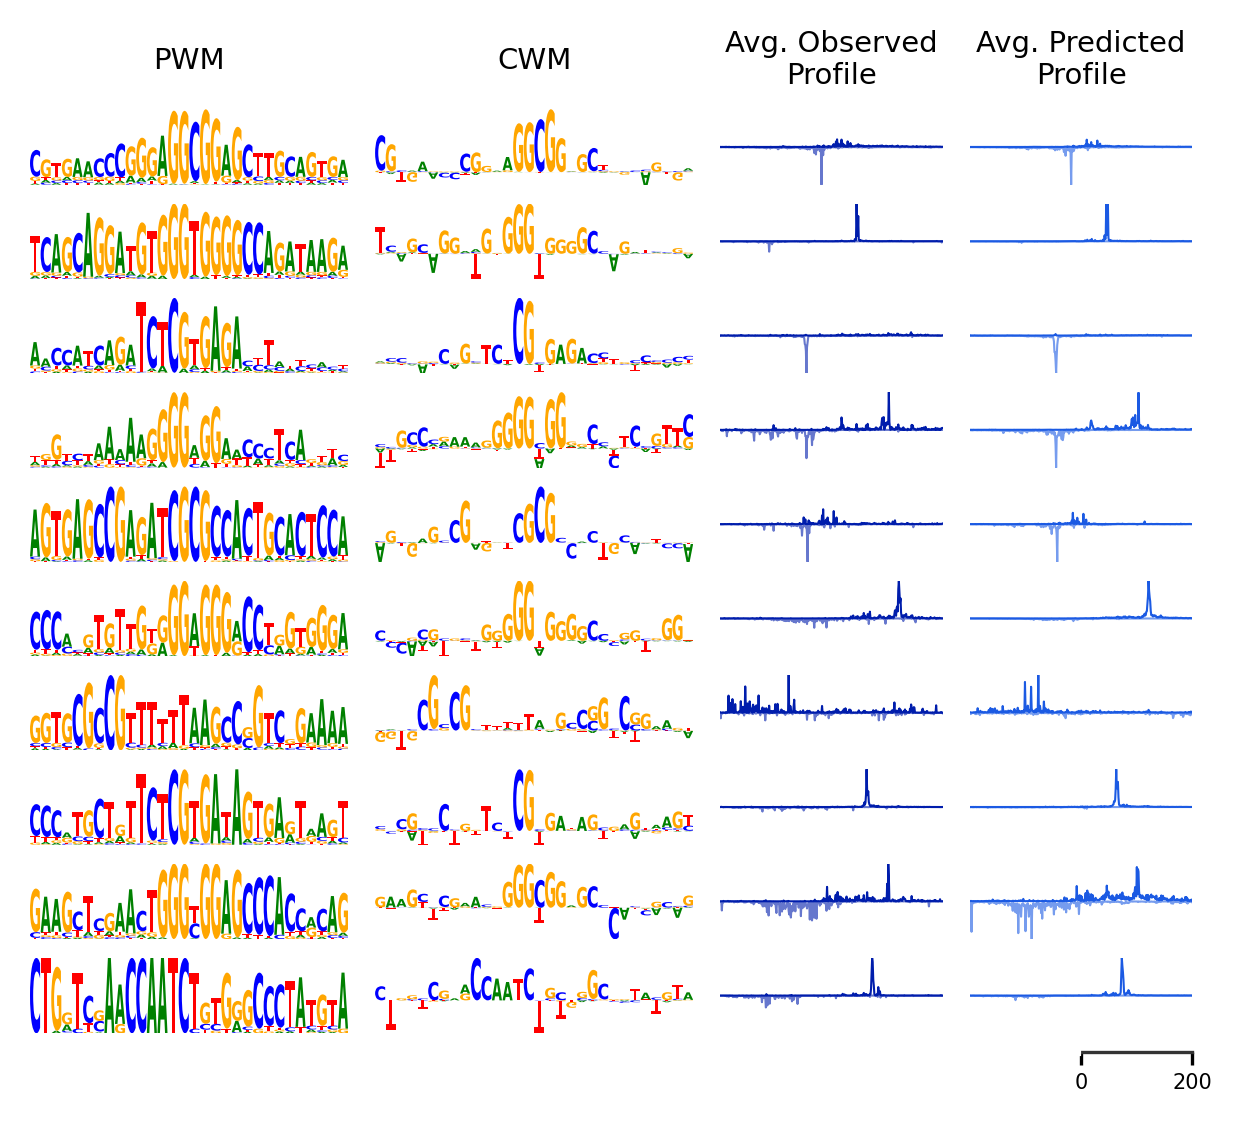

In [84]:
plot_multi_subclusters(counts_modisco_results_path, te_pattern_counts_indexes,
                       save_path = figures_dir + "S2_te_patterns_counts.png" )